# Reversing dynamo

Use reconstructed stochastic data

In [1]:
from UnderdampedLangevinInference import underdampedlangevininference as uli
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
!ls data/

DipoleSourceC2.dat      DipoleSource_PADM2M.dat
DipoleSourceHF1.dat     t_X_eta.mat


In [3]:
filename = 'data/t_X_eta.mat'

In [4]:
def get_dipole_data(filename, variablename):
    mat = scipy.io.loadmat(filename)
    arrays = mat.get(variablename)
    t = np.array(arrays[0,:])
    x = np.array(arrays[1,:])
    x = x - np.mean(x)
    dt = (t[1] - [0])[0]
    dxdt = np.diff(x) / dt
    I = np.cumsum(x) * dt
    t = t[:-1]
    x = x[:-1]
    I = I[:-1]
    return t, x, dxdt, I

t_dipole, x_dipole, dxdt_dipole, I_dipole = get_dipole_data(filename, 't_X_eta')

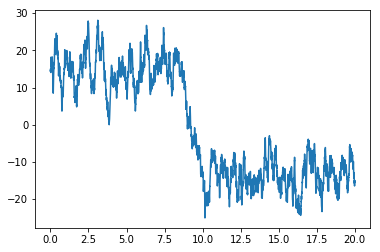

In [5]:
plt.plot(t_dipole[0:10000],x_dipole[0:10000])

In [25]:
i_window = range(0, 500000, 10)

Text(0.5,1,'Gradient')

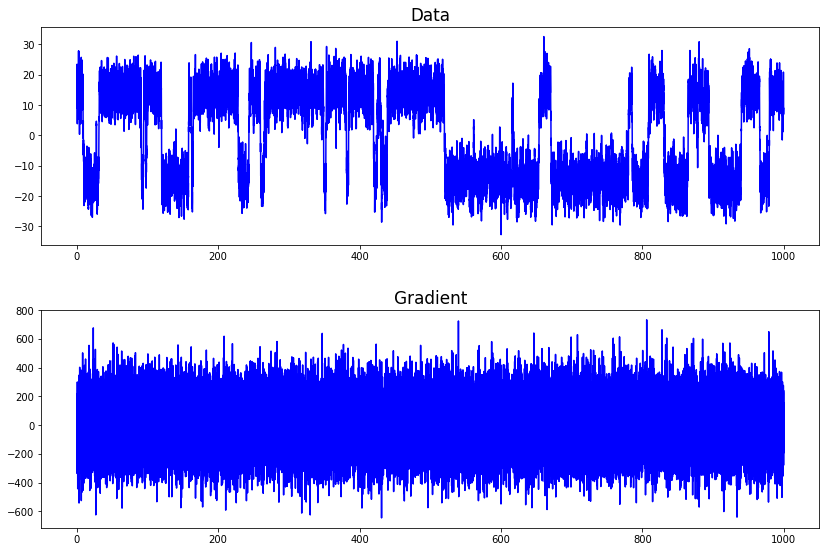

In [26]:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)

plt.subplot(2,1,1)
plt.plot(t_dipole[i_window], x_dipole[i_window],color='b')
plt.title('Data')

plt.subplot(2,1,2)
plt.plot(t_dipole[i_window], dxdt_dipole[i_window],color='b')
plt.title('Gradient')

Text(0.5,1,'Gradient')

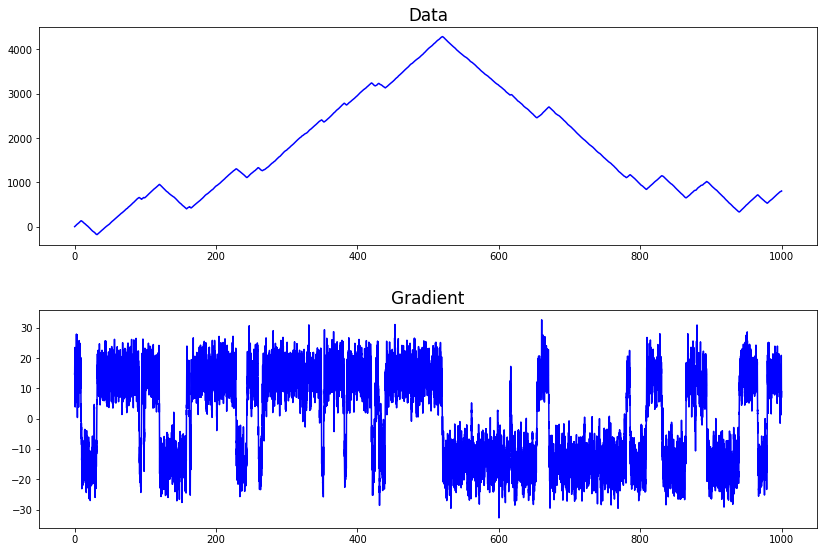

In [27]:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)

plt.subplot(2,1,1)
plt.plot(t_dipole[i_window], I_dipole[i_window],color='b')
plt.title('Data')

plt.subplot(2,1,2)
plt.plot(t_dipole[i_window], x_dipole[i_window],color='b')
plt.title('Gradient')

Text(0.5,1,'Dynamo, (I,x)')

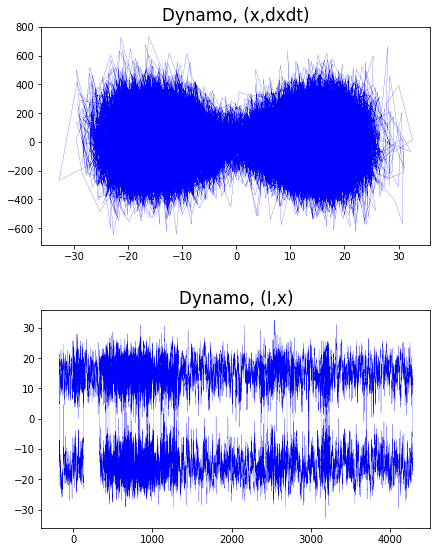

In [28]:
fig_size = [6,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)

plt.subplot(2,1,1)
plt.plot(x_dipole[i_window], dxdt_dipole[i_window],color='b',lw=0.2)
plt.title('Dynamo, (x,dxdt)')

plt.subplot(2,1,2)
plt.plot(I_dipole[i_window], x_dipole[i_window],color='b',lw=0.2)
plt.title('Dynamo, (I,x)')

## Perform inference on dynamo data

In [10]:
################################################################
# II. Perform inference.

xlist_dynamo = np.reshape(I_dipole[i_window], (len(I_dipole[i_window]), 1, 1))
tlist_dynamo = t_dipole[i_window]

data_dynamo = uli.StochasticTrajectoryData(xlist_dynamo,tlist_dynamo) 
S_dynamo = uli.UnderdampedLangevinInference( data_dynamo )

S_dynamo.compute_current(basis = { 'type' : 'polynomial', 'order' : 3} ) 
S_dynamo.compute_diffusion(method='noisy') 
S_dynamo.compute_force()
S_dynamo.compute_force_error() 

S_dynamo.print_report()

Computing the force assuming constant diffusion.
Computing error assuming constant diffusion.
Expected mean squared error: 0.06861423926699713
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[57.83392831]]
Measurement noise covariance:
 [[-3.25781491e-08]]


Text(0.5,1,'Flow field: blue=inferred')

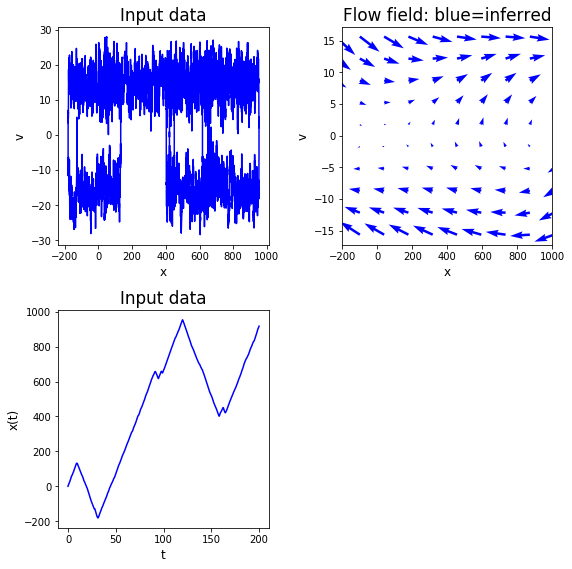

In [11]:
# Prepare Matplotlib:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 2,3

pic_name = "ULI_demo_VdP.png"

# Plot the trajectory (xv phase space):
plt.subplot(H,W,1)
plt.plot(data_dynamo.X_ito[:,0,:],data_dynamo.v_hat[:,0,:],color='b')
plt.xlabel("x")
plt.ylabel("v")
plt.title("Input data")

# Plot the trajectory (x vs t):
plt.subplot(H,W,4)
plt.plot(data_dynamo.t,data_dynamo.X_ito[:,0,:],color='b')
plt.ylabel("x(t)")
plt.xlabel("t")
plt.title("Input data")

# Plot the force field - blue is inferred, black is the exact one used to generate the data.
plt.subplot(H,W,2)
S_dynamo.data.plot_phase_space_forces(S_dynamo.F_ansatz,color='b',zorder=0,width = 10,scale=5)
plt.xlabel("x")
plt.ylabel("v")
plt.xlim([-200,1000])
plt.title("Flow field: blue=inferred")

In [12]:
################################################################
# II. Perform inference.

xlist_dynamo = np.reshape(x_dipole[i_window], (len(x_dipole[i_window]), 1, 1))
tlist_dynamo = t_dipole[i_window]

data_dynamo = uli.StochasticTrajectoryData(xlist_dynamo,tlist_dynamo) 
S_dynamo = uli.UnderdampedLangevinInference( data_dynamo )

S_dynamo.compute_current(basis = { 'type' : 'polynomial', 'order' : 3} ) 
S_dynamo.compute_diffusion(method='noisy') 
S_dynamo.compute_force()
S_dynamo.compute_force_error() 

S_dynamo.print_report()

Computing the force assuming constant diffusion.
Computing error assuming constant diffusion.
Expected mean squared error: 0.0004697309133294905
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[4536097.99584501]]
Measurement noise covariance:
 [[0.00334332]]


Text(0.5,1,'Flow field: blue=inferred')

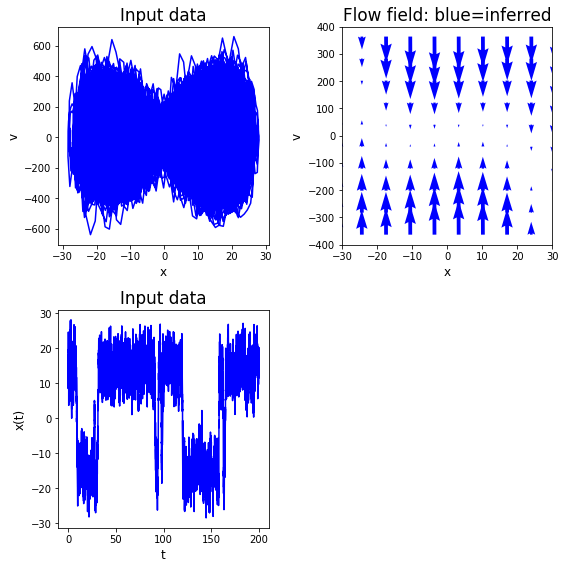

In [20]:
# Prepare Matplotlib:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 2,3

pic_name = "ULI_demo_VdP.png"

# Plot the trajectory (xv phase space):
plt.subplot(H,W,1)
plt.plot(data_dynamo.X_ito[:,0,:],data_dynamo.v_hat[:,0,:],color='b')
plt.xlabel("x")
plt.ylabel("v")
plt.title("Input data")

# Plot the trajectory (x vs t):
plt.subplot(H,W,4)
plt.plot(data_dynamo.t,data_dynamo.X_ito[:,0,:],color='b')
plt.ylabel("x(t)")
plt.xlabel("t")
plt.title("Input data")

# Plot the force field - blue is inferred, black is the exact one used to generate the data.
plt.subplot(H,W,2)
S_dynamo.data.plot_phase_space_forces(S_dynamo.F_ansatz,color='b',zorder=0,width = 10,scale=0.001)
plt.xlabel("x")
plt.ylabel("v")
plt.xlim([-30,30])
plt.title("Flow field: blue=inferred")